# Data description

In [144]:
import re
import os
import json
from itertools import chain

import bs4 as bs
import numpy as np
import pandas as pd
import seaborn as sns
from textwrap import wrap
from statistics import mode
import matplotlib.pyplot as plt

from utilities import *

In [2]:
here = os.getcwd()
project_path = os.path.dirname(here)
data_path = os.path.join(project_path, "data")
visualizations_path = os.path.join(project_path, "visualizations")
os.makedirs(visualizations_path, exist_ok=True)

## Senators distribution

In [3]:
senators_path = os.path.join(data_path, "session_29-12-2020_senators.csv")
senators = pd.read_csv(senators_path)
senators.head(2)

,name,vote,senator,province,party
0,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,ALIANZA FRENTE PARA LA VICTORIA
1,Roberto Gustavo Basualdo,negativo,BASUALDO ROBERTO GUSTAVO,SAN JUAN,ALIANZA CAMBIEMOS SAN JUAN


In [4]:
senators.party.sort_values().unique().tolist()

['ALIANZA CAMBIEMOS',
 'ALIANZA CAMBIEMOS SAN JUAN',
 'ALIANZA ENCUENTRO CORRIENTES',
 'ALIANZA FRENTE P/VICTORIA (PERONISMO PAMPEANO)',
 'ALIANZA FRENTE PARA LA VICTORIA',
 'ALIANZA UNIÓN POR CÓRDOBA',
 'AVANZAR Y CAMBIEMOS POR SAN LUIS',
 'CAMBIEMOS BUENOS AIRES',
 'CAMBIEMOS FUERZA CÍVICA RIOJANA',
 'CHUBUT SOMOS TODOS',
 'FRENTE AMPLIO FORMOSEÑO CAMBIEMOS',
 'FRENTE CAMBIEMOS',
 'FRENTE CÍVICO POR SANTIAGO',
 'FRENTE CÍVICO Y SOCIAL',
 'FRENTE DE LA VICTORIA',
 'FRENTE DE TODOS',
 'FRENTE JUJEÑO CAMBIEMOS',
 'FRENTE JUSTICIALISTA',
 'FRENTE PARA LA VICTORIA',
 'FRENTE RENOVADOR DE LA CONCORDIA',
 'FRENTE TODOS',
 'FRENTE UNIDAD JUSTICIALISTA SAN LUIS',
 'JUNTOS POR EL CAMBIO',
 'JUNTOS POR EL CAMBIO TIERRA DEL FUEGO',
 'JUNTOS SOMOS RÍO NEGRO',
 'UNIDAD CIUDADANA',
 'UNIÓN PARA VIVIR MEJOR CAMBIEMOS']

In [5]:
province2parties = senators.groupby("province")["party"].apply(
    lambda x: pd.Series(x).unique().tolist()
).to_dict()

with open(f"{visualizations_path}/province2parties.json", "w") as f:
    json.dump(
        province2parties, f, ensure_ascii=False, indent=4
    )

province2parties

{'BUENOS AIRES': ['CAMBIEMOS BUENOS AIRES', 'UNIDAD CIUDADANA'],
 'CATAMARCA': ['ALIANZA FRENTE PARA LA VICTORIA', 'FRENTE CÍVICO Y SOCIAL'],
 'CHACO': ['FRENTE DE TODOS', 'JUNTOS POR EL CAMBIO'],
 'CHUBUT': ['ALIANZA FRENTE PARA LA VICTORIA', 'CHUBUT SOMOS TODOS'],
 'CIUDAD AUTÓNOMA DE BUENOS AIRES': ['JUNTOS POR EL CAMBIO',
  'FRENTE DE TODOS'],
 'CORRIENTES': ['ALIANZA FRENTE PARA LA VICTORIA',
  'ALIANZA ENCUENTRO CORRIENTES'],
 'CÓRDOBA': ['ALIANZA UNIÓN POR CÓRDOBA', 'ALIANZA CAMBIEMOS'],
 'ENTRE RÍOS': ['JUNTOS POR EL CAMBIO', 'FRENTE TODOS'],
 'FORMOSA': ['FRENTE DE LA VICTORIA', 'FRENTE AMPLIO FORMOSEÑO CAMBIEMOS'],
 'JUJUY': ['FRENTE JUJEÑO CAMBIEMOS', 'FRENTE JUSTICIALISTA'],
 'LA PAMPA': ['ALIANZA FRENTE P/VICTORIA (PERONISMO PAMPEANO)',
  'ALIANZA CAMBIEMOS'],
 'LA RIOJA': ['CAMBIEMOS FUERZA CÍVICA RIOJANA'],
 'MENDOZA': ['ALIANZA CAMBIEMOS', 'ALIANZA FRENTE PARA LA VICTORIA'],
 'MISIONES': ['FRENTE RENOVADOR DE LA CONCORDIA', 'FRENTE CAMBIEMOS'],
 'NEUQUÉN': ['JUNTOS POR 

In [11]:
party2party_family = dict()

for key, values in province2parties.items():
    for v in values:
        if re.search(r"victoria|frente\s(.*?)?todos", v, re.I):
            party_family = "Frente para la victoria"
        elif re.search(r"cambi(o|emos)", v, re.I):
            party_family = "Juntos por el cambio"
        else:
            party_family = "Otro"
        if v not in party2party_family:
            party2party_family[v] = party_family
            print(f"- {v} --> {party_family}")

- CAMBIEMOS BUENOS AIRES --> Juntos por el cambio
- UNIDAD CIUDADANA --> Otro
- ALIANZA FRENTE PARA LA VICTORIA --> Frente para la victoria
- FRENTE CÍVICO Y SOCIAL --> Otro
- FRENTE DE TODOS --> Frente para la victoria
- JUNTOS POR EL CAMBIO --> Juntos por el cambio
- CHUBUT SOMOS TODOS --> Otro
- ALIANZA ENCUENTRO CORRIENTES --> Otro
- ALIANZA UNIÓN POR CÓRDOBA --> Otro
- ALIANZA CAMBIEMOS --> Juntos por el cambio
- FRENTE TODOS --> Frente para la victoria
- FRENTE DE LA VICTORIA --> Frente para la victoria
- FRENTE AMPLIO FORMOSEÑO CAMBIEMOS --> Juntos por el cambio
- FRENTE JUJEÑO CAMBIEMOS --> Juntos por el cambio
- FRENTE JUSTICIALISTA --> Otro
- ALIANZA FRENTE P/VICTORIA (PERONISMO PAMPEANO) --> Frente para la victoria
- CAMBIEMOS FUERZA CÍVICA RIOJANA --> Juntos por el cambio
- FRENTE RENOVADOR DE LA CONCORDIA --> Otro
- FRENTE CAMBIEMOS --> Juntos por el cambio
- JUNTOS SOMOS RÍO NEGRO --> Otro
- ALIANZA CAMBIEMOS SAN JUAN --> Juntos por el cambio
- FRENTE UNIDAD JUSTICIALISTA

In [32]:
senators["party_family"] = senators.party.map(
    lambda x: party2party_family.get(x, x)
)

(
    senators
    .groupby("party_family")["party"]
    .agg(
        N=lambda x: pd.Series(x).nunique(),
        party=lambda x: pd.Series(x).unique().tolist()
    )
    .reset_index()
    .explode(column="party")
    .sort_values(by=["party_family", "party"], ascending=True, ignore_index=True)
)

,party_family,N,party
0,Frente para la victoria,6,ALIANZA FRENTE P/VICTORIA (PERONISMO PAMPEANO)
1,Frente para la victoria,6,ALIANZA FRENTE PARA LA VICTORIA
2,Frente para la victoria,6,FRENTE DE LA VICTORIA
3,Frente para la victoria,6,FRENTE DE TODOS
4,Frente para la victoria,6,FRENTE PARA LA VICTORIA
5,Frente para la victoria,6,FRENTE TODOS
6,Juntos por el cambio,11,ALIANZA CAMBIEMOS
7,Juntos por el cambio,11,ALIANZA CAMBIEMOS SAN JUAN
8,Juntos por el cambio,11,AVANZAR Y CAMBIEMOS POR SAN LUIS
9,Juntos por el cambio,11,CAMBIEMOS BUENOS AIRES


In [33]:
senators.describe()

,name,vote,senator,province,party,party_family
count,70,70,70,70,70,70
unique,70,4,70,24,27,3
top,Víctor Zimmermann,positivo,ZIMMERMANN VICTOR,CORRIENTES,FRENTE DE TODOS,Frente para la victoria
freq,1,38,1,3,12,30


In [76]:
senators.vote.unique()

array(['positivo', 'negativo', 'ausente', 'abstención'], dtype=object)

In [34]:
senators_party_count = senators.party.value_counts().to_frame().reset_index()
save_dataframe(
    senators_party_count, folder=visualizations_path, filename="senators_party_count"
)
senators_party_family_count = senators.party_family.value_counts().to_frame().reset_index()
save_dataframe(
    senators_party_family_count, folder=visualizations_path, filename="senators_party_family_count"
)
senators_province_count = senators.province.value_counts().to_frame().reset_index()
save_dataframe(
    senators_province_count, folder=visualizations_path, filename="senators_province_count"
)

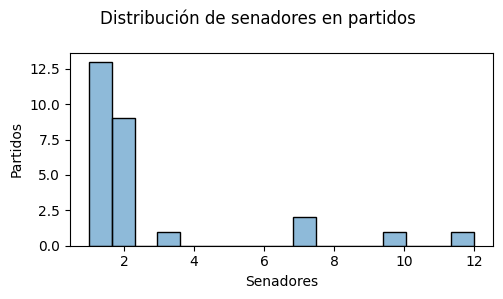

In [49]:
fig, ax = plt.subplots(figsize=(5,3))
sns.histplot(data=senators_party_count, ax=ax)
ax.set_xlabel(f"Senadores")
ax.set_ylabel(f"Partidos")
ax.get_legend().remove()
plt.suptitle(f"Distribución de senadores en partidos")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"distrib_histplot_senators_parties.png"))

## Vote information

In [79]:
senators_vote_by_party = (
    senators
    .groupby(["party", "vote"])
    .size()
    .reset_index()
    .merge(senators_party_count)
    .assign(party=lambda x: x.party.str.title())
    .rename(columns={0:"n_votes", "count":"n_senators"})
    .sort_values(by=["n_senators","party"], ascending=[False,True], ignore_index=True)
    .pivot_table(
        index=["party"], columns=["vote"],
        values=["n_votes"],fill_value=0
    )
)
senators_vote_by_party.columns = senators_vote_by_party.columns.get_level_values(1)
senators_vote_by_party.columns.name = ""
senators_vote_by_party.head()

,abstención,ausente,negativo,positivo
party,,,,
Alianza Cambiemos,0,0,4,3
Alianza Cambiemos San Juan,0,0,1,0
Alianza Encuentro Corrientes,0,0,1,0
Alianza Frente P/Victoria (Peronismo Pampeano),0,0,0,2
Alianza Frente Para La Victoria,0,0,3,7


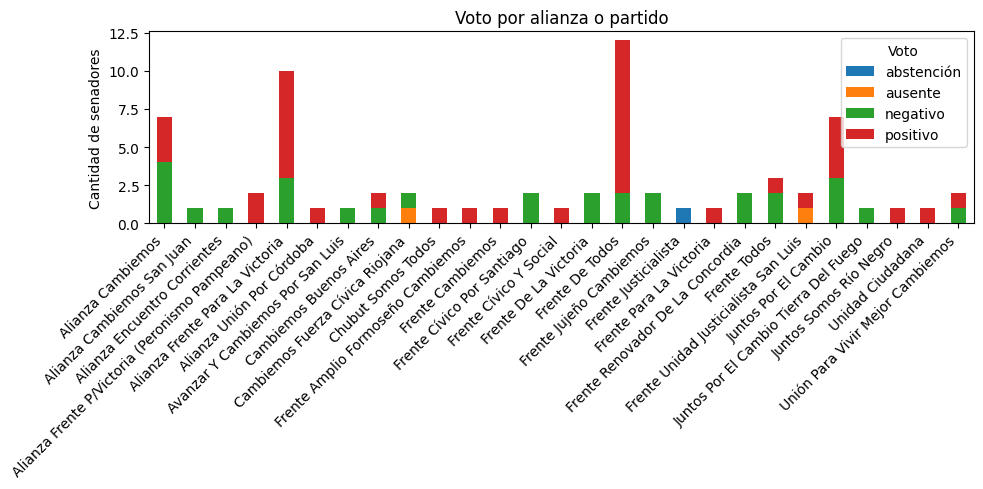

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
senators_vote_by_party.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Cantidad de senadores")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title="Voto")
plt.title("Voto por alianza o partido")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"senators_vote_by_party.png"))

In [56]:
senators_vote_by_party.reset_index(inplace=True)
save_dataframe(
    senators_vote_by_party[["party","positivo", "negativo", "ausente", "abstención"]],
    folder=visualizations_path, filename="senators_vote_by_party"
)

In [115]:
senators_vote_by_family = (
    senators
    .groupby(["party_family", "vote"])
    .size()
    .reset_index()
    .merge(senators_party_family_count)
    .rename(columns={0:"n_votes", "count":"n_senators"})
    .sort_values(by=["n_senators","party_family"], ascending=[False,True], ignore_index=True)
    .pivot_table(
        index=["party_family"], columns=["vote"],
        values=["n_votes"],fill_value=0
    )
)
senators_vote_by_family.columns = senators_vote_by_family.columns.get_level_values(1)
senators_vote_by_family.columns.name = ""
senators_vote_by_family

,abstención,ausente,negativo,positivo
party_family,,,,
Frente para la victoria,0,0,9,21
Juntos por el cambio,0,1,15,11
Otro,1,1,5,6


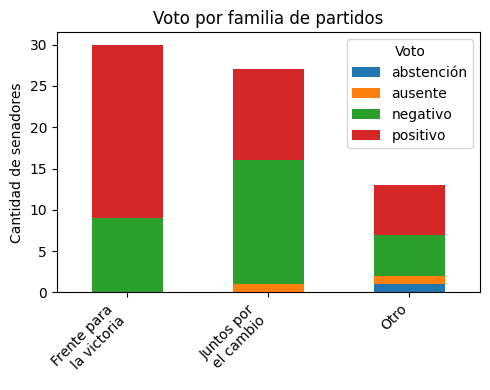

In [112]:
fig, ax = plt.subplots(figsize=(5,4))
senators_vote_by_family.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Cantidad de senadores")
ax.set_xticklabels(
    ['\n'.join(wrap(l.get_text(), 12)) for l in ax.get_xticklabels()],
    rotation=45, ha='right'
)
ax.legend(title="Voto")
plt.title("Voto por familia de partidos")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"senators_vote_by_party_family.png"))

In [116]:
senators_vote_by_family.reset_index(inplace=True)
save_dataframe(
    senators_vote_by_family[["party_family","positivo", "negativo", "ausente", "abstención"]],
    folder=visualizations_path, filename="senators_vote_by_party_family"
)

## Speech data

In [117]:
speech_path = os.path.join(data_path, "session_29-12-2020_discourse.xml")

with open(speech_path, "r") as f:
    speech_text = f.read() 

speech = bs.BeautifulSoup(speech_text, "lxml")

/tmp/ipykernel_332161/2504822991.py:6: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  speech = bs.BeautifulSoup(speech_text, "lxml")


In [118]:
speakers = [s.get_attribute_list("speaker") for s in speech.find_all("discourse", {"speech":"true"})]
speakers = list(set(chain(*speakers)))
speakers_prep = list(map(preprocess_name,speakers))
print(speakers[:3])
print(speakers_prep[:3])
# check that every speaker name is only once
assert all([speakers_prep.count(sp) == 1 for sp in speakers_prep])
speakers_map = dict(zip(speakers_prep, speakers))

['Fernández de Kirchner', 'Mirkin', 'Poggi']
['de fernandez kirchner', 'mirkin', 'poggi']


In [126]:
# check that each speaker match with only one senator
senators["speaker"] = senators.name.apply(
    lambda x: match_senator_name(x, list(speakers_map.keys()))
)
senators["n_speaker"] = senators.speaker.str.len().sort_values()
senators.sort_values(by=["n_speaker"], ascending=True, inplace=True)

In [127]:
# some senators has no speaker (did they talked?)
senators.head()

,name,vote,senator,province,party,party_family,speaker,n_speaker
51,Carlos Alberto Reutemann,negativo,REUTEMANN CARLOS ALBERTO,SANTA FE,ALIANZA CAMBIEMOS,Juntos por el cambio,[],0
42,Gerardo Antenor Montenegro,negativo,MONTENEGRO GERARDO ANTENOR,SANTIAGO DEL ESTERO,FRENTE DE TODOS,Frente para la victoria,[],0
35,Juan Carlos Marino,negativo,MARINO JUAN CARLOS,LA PAMPA,ALIANZA CAMBIEMOS,Juntos por el cambio,[],0
37,Julio César Martínez,negativo,MARTÍNEZ JULIO CÉSAR,LA RIOJA,CAMBIEMOS FUERZA CÍVICA RIOJANA,Juntos por el cambio,[],0
28,Edgardo Darío Kueider,positivo,KUEIDER EDGARDO DARÍO,ENTRE RÍOS,FRENTE TODOS,Frente para la victoria,[],0


In [128]:
# and one matched with two speakers (but mayibe the same? more than one Rodríguez seen in attendees)
# Matías David Rodríguez, Laura Rodríguez Machado, Adolfo Rodríguez Saá
senators.tail()

,name,vote,senator,province,party,party_family,speaker,n_speaker
66,María Clara Del Valle Vega,ausente,VEGA MARÍA CLARA DEL VALLE,LA RIOJA,CAMBIEMOS FUERZA CÍVICA RIOJANA,Juntos por el cambio,[vega],1
67,Pamela Fernanda Verasay,positivo,VERASAY PAMELA FERNANDA,MENDOZA,ALIANZA CAMBIEMOS,Juntos por el cambio,[verasay],1
68,Alberto Edgardo Weretilneck,positivo,WERETILNECK ALBERTO EDGARDO,RÍO NEGRO,JUNTOS SOMOS RÍO NEGRO,Otro,[weretilneck],1
0,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,ALIANZA FRENTE PARA LA VICTORIA,Frente para la victoria,[almiron],1
54,Laura Rodríguez Machado,positivo,RODRÍGUEZ MACHADO LAURA ELENA,CÓRDOBA,ALIANZA CAMBIEMOS,Juntos por el cambio,"[rodriguez, machado rodriguez]",2


In [129]:
# data to review manually
#senators[["name", "speaker"]].set_index("name").to_json(
#    "map_name2speaker.json", orient="index", indent=4, force_ascii=False
#)
senators.drop(columns=["speaker", "n_speaker"], inplace=True)

In [130]:
with open("map_name2speaker.json", "r") as f:
    map_name2speaker = json.load(f)

In [131]:
senators["speaker"] = senators.name.apply(lambda x:
    speakers_map.get(map_name2speaker.get(x).get("speaker"))
)
senators.sort_index(inplace=True)

In [132]:
senators.head()

,name,vote,senator,province,party,party_family,speaker
0,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,ALIANZA FRENTE PARA LA VICTORIA,Frente para la victoria,Almirón
1,Roberto Gustavo Basualdo,negativo,BASUALDO ROBERTO GUSTAVO,SAN JUAN,ALIANZA CAMBIEMOS SAN JUAN,Juntos por el cambio,Basualdo
2,Pablo Daniel Blanco,negativo,BLANCO PABLO DANIEL,"TIERRA DEL FUEGO, ANTÁRTIDA E ISLAS DEL ATLÁNT...",JUNTOS POR EL CAMBIO TIERRA DEL FUEGO,Juntos por el cambio,Blanco
3,Inés Imelda Blas,negativo,BLAS INÉS IMELDA,CATAMARCA,ALIANZA FRENTE PARA LA VICTORIA,Frente para la victoria,Blas
4,Néstor Braillard Poccard,negativo,BRAILLARD POCCARD NÉSTOR PEDRO,CORRIENTES,ALIANZA ENCUENTRO CORRIENTES,Otro,Braillard Poccard


In [133]:
senators["speech"] = senators.speaker.apply(lambda x: assign_speech(x, speech))
senators["speech_prep"] = senators.speech.apply(lambda x: list(map(preprocess_text, x)))
senators["n_interventions"] = senators.speech_prep.str.len()
senators["n_tokens_interventions"] = senators.speech_prep.apply(
    lambda x: list(map(count_tokens, x))
)
senators["n_unique_tokens_interventions"] = senators.speech_prep.apply(
    lambda x: list(map(lambda z: count_tokens(z, unique=True), x))
)
senators["mean_tokens_interventions"] = senators["n_tokens_interventions"].apply(
    lambda x: np.mean(x) if len(x)>0 else 0
)
senators["mean_unique_tokens_interventions"] = senators["n_unique_tokens_interventions"].apply(
    lambda x: np.mean(x) if len(x)>0 else 0
)
senators["median_tokens_interventions"] = senators["n_tokens_interventions"].apply(
    lambda x: np.median(x) if len(x)>0 else 0
)
senators["median_unique_tokens_interventions"] = senators["n_unique_tokens_interventions"].apply(
    lambda x: np.median(x) if len(x)>0 else 0
)

In [134]:
senators.sort_values(by="n_interventions", ascending=False).head(3)

,name,vote,senator,province,party,party_family,speaker,speech,speech_prep,n_interventions,n_tokens_interventions,n_unique_tokens_interventions,mean_tokens_interventions,mean_unique_tokens_interventions,median_tokens_interventions,median_unique_tokens_interventions
30,Claudia Ledesma Abdala,negativo,LEDESMA ABDALA DE ZAMORA CLAUDIA,SANTIAGO DEL ESTERO,FRENTE CÍVICO POR SANTIAGO,Otro,Ledesma Abdala,"[Senador Mayans: su micrófono. Disculpe, senad...",[senador mayans su micrófono disculpe senador ...,46,"[7, 2, 4, 12, 5, 8, 4, 8, 8, 8, 7, 7, 7, 8, 7,...","[6, 2, 4, 12, 5, 7, 4, 8, 7, 7, 6, 7, 7, 8, 6,...",6.717391,6.369565,7.0,6.0
32,Martín Lousteau,positivo,LOUSTEAU MARTÍN,CIUDAD AUTÓNOMA DE BUENOS AIRES,JUNTOS POR EL CAMBIO,Juntos por el cambio,Lousteau,"[Muchas gracias, senadora. Tiene ahora la pala...",[muchas gracias senadora tiene ahora la palabr...,21,"[11, 9, 19, 1, 15, 10, 9, 10, 11, 10, 10, 3, 7...","[9, 9, 17, 1, 15, 10, 8, 10, 10, 8, 10, 3, 7, ...",164.523810,53.571429,10.0,9.0
54,Laura Rodríguez Machado,positivo,RODRÍGUEZ MACHADO LAURA ELENA,CÓRDOBA,ALIANZA CAMBIEMOS,Juntos por el cambio,Rodríguez Machado,"[Gracias, presidente. Ojalá que pueda poner en...",[gracias presidente ojalá que pueda poner en m...,19,"[1327, 13, 11, 12, 12, 10, 13, 14, 11, 13, 11,...","[470, 11, 11, 11, 12, 10, 11, 14, 11, 12, 10, ...",83.526316,37.105263,12.0,11.0


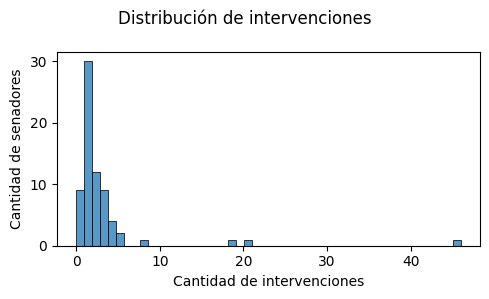

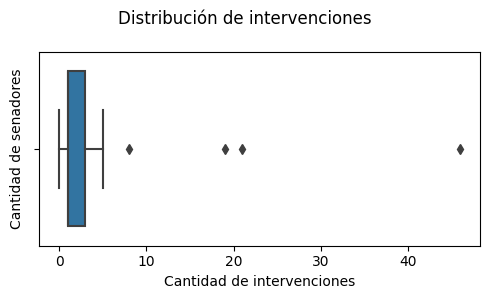

In [146]:
fig, ax = plt.subplots(figsize=(5,3))
sns.histplot(data=senators, x="n_interventions", ax=ax)
ax.set_xlabel("Cantidad de intervenciones")
ax.set_ylabel("Cantidad de senadores")
plt.suptitle("Distribución de intervenciones")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"distrib_histplot_interventions.png"))

fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(data=senators, x="n_interventions", ax=ax)
ax.set_xlabel("Cantidad de intervenciones")
ax.set_ylabel("Cantidad de senadores")
plt.suptitle("Distribución de intervenciones")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"distrib_boxplot_interventions.png"))

In [145]:
# INTERVENTIONS
(
    senators
    .n_interventions
    .describe()
    .to_frame()
    .T
    .drop(columns=["count"])
    .assign(
        median=np.median(senators.n_interventions),
        mode=mode(senators.n_interventions)
    )
    .reset_index(drop=True)
)

,mean,std,min,25%,50%,75%,max,median,mode
0,2.871429,6.229712,0.0,1.0,1.0,3.0,46.0,1.0,1


In [66]:
senators_with_no_speech = (senators.speech.str.len()==0).sum()
print(f"{senators_with_no_speech} senadores no intervinieron en la sesión.")

9 senadores no intervinieron en la sesión.


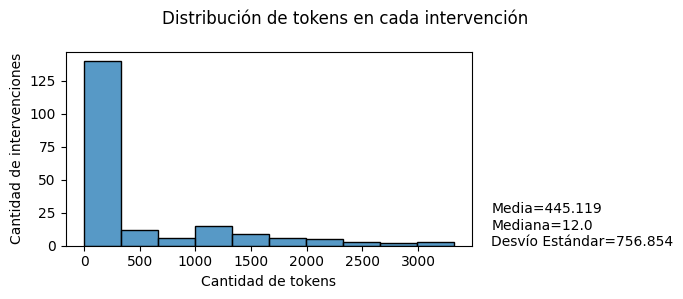

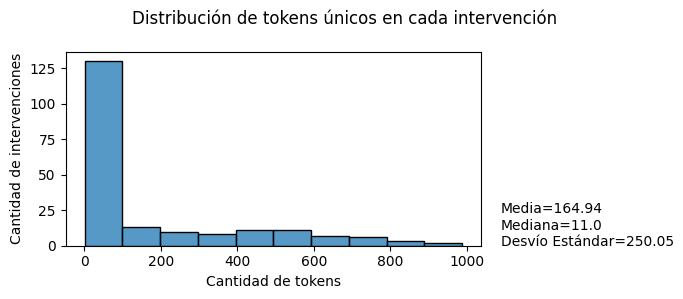

In [67]:
cols = ["n_tokens_interventions", "n_unique_tokens_interventions"]
titles = ["Distribución de tokens en cada intervención", "Distribución de tokens únicos en cada intervención"]

for col, title in zip(cols, titles):
    fig, ax = plt.subplots(figsize=(7,3))
    data = list(chain(*senators[col].to_list()))
    mean, meadian, std = calculate_univariant_metrics(data, round_=3)
    sns.histplot(data=data, ax=ax, bins=10)
    ax.set_xlabel("Cantidad de tokens")
    ax.set_ylabel("Cantidad de intervenciones")
    x_lim, y_lim = ax.get_xlim()[1], ax.get_ylim()[0]
    plt.suptitle(title)
    plt.text(
        x_lim + x_lim*0.05, y_lim,
        f"Media={mean}\nMediana={meadian}\nDesvío Estándar={std}",
        horizontalalignment='left',
        fontsize=10
    )
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_path,f"distrib_histplot_{col}.png"))

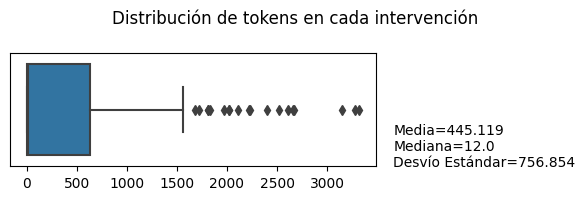

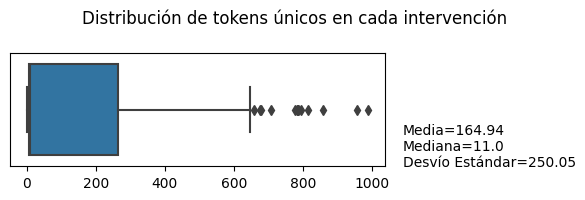

In [68]:
cols = ["n_tokens_interventions", "n_unique_tokens_interventions"]
titles = ["Distribución de tokens en cada intervención", "Distribución de tokens únicos en cada intervención"]

for col, title in zip(cols, titles):
    fig, ax = plt.subplots(figsize=(6,2))
    data = list(chain(*senators[col].to_list()))
    mean, meadian, std = calculate_univariant_metrics(data, round_=3)
    sns.boxplot(x=data, ax=ax)
    ax.set_xlabel("")
    ax.tick_params(left=False)
    x_lim, y_lim = ax.get_xlim()[1], ax.get_ylim()[0]
    plt.text(
        x_lim + x_lim*0.05, y_lim,
        f"Media={mean}\nMediana={meadian}\nDesvío Estándar={std}",
        horizontalalignment='left',
        fontsize=10
    )
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_path,f"distrib_boxplot_{col}.png"))

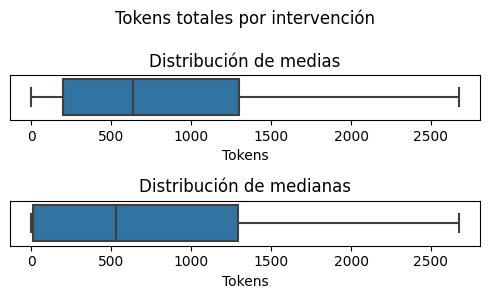

In [69]:
cols = ["mean_tokens_interventions", "median_tokens_interventions"]
titles = ["Distribución de medias", "Distribución de medianas"]

fig, axs = plt.subplots(2,1, figsize=(5,3))

i = 0
for col,title in zip(cols, titles):
    sns.boxplot(data=senators, x=col, ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_xlabel("Tokens")
    axs[i].tick_params(left=False)
    i += 1
plt.suptitle("Tokens totales por intervención")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"distrib_boxplot_tokens.png"))

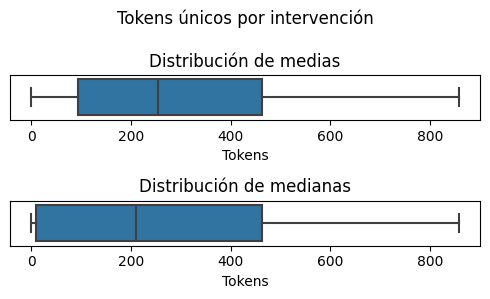

In [70]:
cols = ["mean_unique_tokens_interventions", "median_unique_tokens_interventions"]
titles = ["Distribución de medias", "Distribución de medianas"]

fig, axs = plt.subplots(2,1, figsize=(5,3))

i = 0
for col,title in zip(cols, titles):
    sns.boxplot(data=senators, x=col, ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_xlabel("Tokens")
    axs[i].tick_params(left=False)
    i += 1
plt.suptitle("Tokens únicos por intervención")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"distrib_boxplot_tokens_uniq.png"))

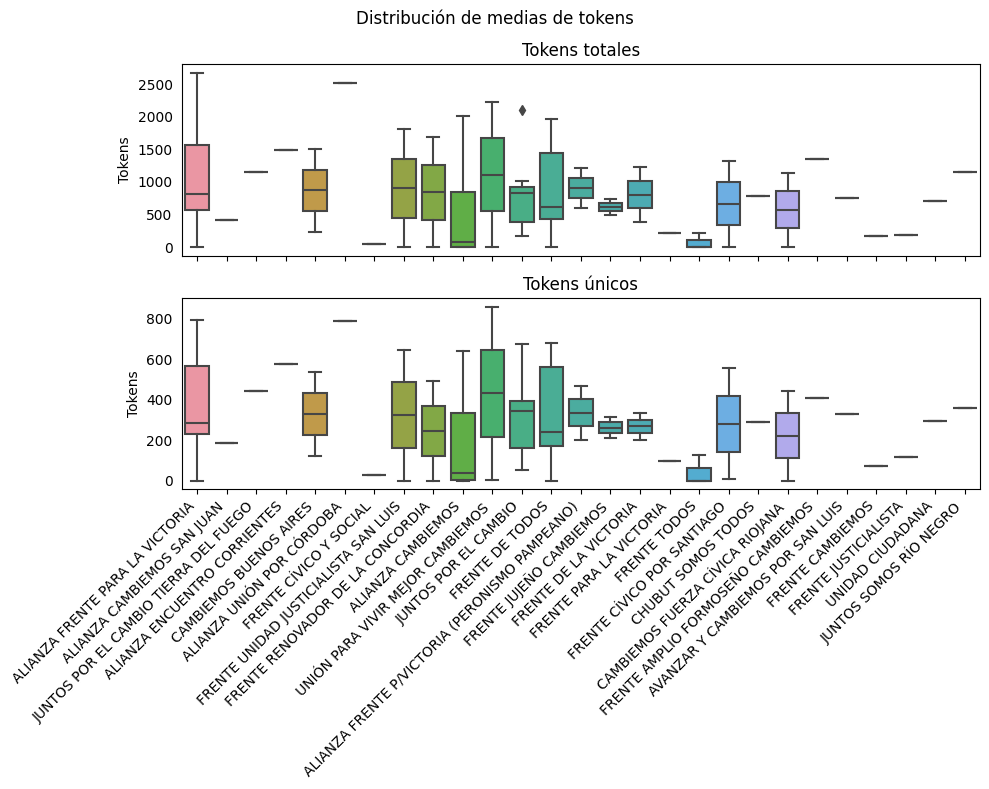

In [150]:
cols = ["mean_tokens_interventions", "mean_unique_tokens_interventions"]
titles = ["Tokens totales", "Tokens únicos"]

fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

i = 0
for col,title in zip(cols, titles):
    sns.boxplot(data=senators, x="party", y=col, ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Tokens")
    axs[i].tick_params(left=False)
    i += 1
plt.xticks(rotation=45, horizontalalignment="right")
plt.suptitle("Distribución de medias de tokens")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"distrib_boxplot_mean_tokens_party.png"))

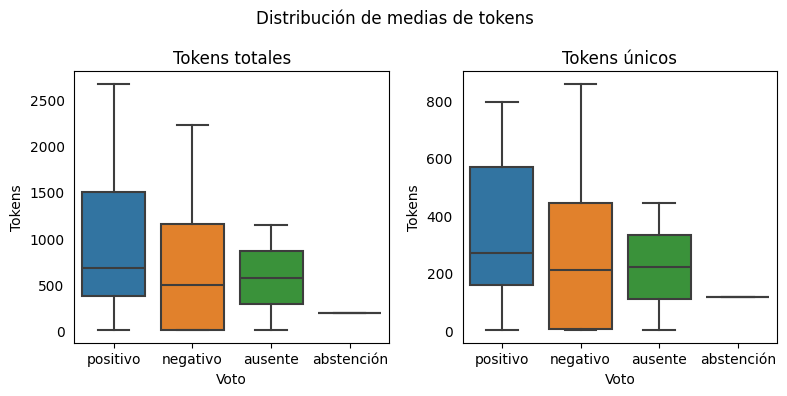

In [151]:
cols = ["mean_tokens_interventions", "mean_unique_tokens_interventions"]
titles = ["Tokens totales", "Tokens únicos"]

fig, axs = plt.subplots(1,2, figsize=(8,4))

i = 0
for col,title in zip(cols, titles):
    sns.boxplot(data=senators, x="vote", y=col, ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_xlabel("Voto")
    axs[i].set_ylabel("Tokens")
    axs[i].tick_params(left=False)
    i += 1
plt.suptitle("Distribución de medias de tokens")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"distrib_boxplot_mean_tokens_party_family.png"))

In [153]:
out_file = os.path.join(data_path, "session_speech.csv")
senators[["name", "vote", "speech"]].to_csv(out_file, index = False)